
# Data Engineering Capstone Project

#### Project Summary
The goal of this project is to create a single-source-of-truth date warehouse that can serve as the foundation for creating logical data marts for analytics purposes on I94 immigration data, city temperatures data and U.S. demographics data.    

The project contains the following steps:
1. Scope the Project and Data
2. Explore and Assess the Data
3. Define the Data Model
4. Run ETL to Model the Data
5. Complete Project Write Up

### Import libraries

In [1]:
import pandas as pd
import pyspark
import os
import logging
import datetime as dt
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, monotonically_increasing_id, year, month, to_date, col

### Create Spark Session

In [2]:
spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

## 1. Project Scope and Data
---

#### Scope 
In order to create a single-source-of-truth data warehouse, the following steps are executed:

* Load dataset into Spark dataframes
* Exploratory data analysis of I94 immigration dataset to identify missing values, empty records, etc, informing the data preprocessing step downstream
* Exploratory data analysis of U.S. city demographics dataset to identify missing values, empty records, etc, informing the data preprocessing step downstream 
* Exploratory data analysis of world temperatures dataset to identify missing values, empty records, etc, informing the data preprocessing step downstream 
* Execute data proprocessing tasks for all datasets
* Create immigration fact table from preprocessed I94 immigration dataset 
* Create dimension tables:
    * Create immigrant demographics dimension table from preprocessed I94 immigration dataset. Relates to immigration fact table by `cic_id` (unique record id) 
    * Create us city demographics dimension table from U.S. city demographics dataset. Relates to immigration fact table by `state_code`
    * Create world temperature dimension table from preprocessed world temperature dataset. Relates to immigration fact table by composite key `city_name`
    * Create country dimension table from `i94cit_i94res` data in the I94_SAS_Labels_Descriptions.SAS file
    * Create city dimension table from `dim_i94port` data in the I94_SAS_Labels_Descriptions.SAS file
    * Create state dimension table from `dim_i94addr` data in I94_SAS_Labels_Descriptions.SAS file
    
##### Datasets:

| Data Set | Format  | Description |
|  :-     |  :-    |  :-        |
|[I94 Immigration Data](https://www.trade.gov/national-travel-and-tourism-office)| SAS | Dataset contains international visitor arrival statistics by world regions, mode of transportation, port of entry, demographics, visa type, etc.|
|[World Temperature Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data)| CSV | Dataset contains monthly average temperatures by city.|
|[U.S. City Demographic Data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)| CSV | Dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000.|

##### Tech Stack:
We've made use of the followng technologies in this project: 
- [AWS S3](https://aws.amazon.com/s3/): data storage
- Apache Spark ([PySpark](https://spark.apache.org/docs/latest/api/python/#:~:text=PySpark%20is%20an%20interface%20for,data%20in%20a%20distributed%20environment.)): for reading data from the source (e.g. customer systems / internal systems etc), preprocessing the data and creates fact and dimension tables, and writing the data into fact and dimension tabls on S3.

## 2. Load and Preprocess Data

* Load datasets into Spark dataframes
* Remove duplicates, empty rows and columns with significant amount of missing values (>85%)

### I94 Immigration Data
---

#### Load I94 Immigration Data

In [3]:
# Load data for April 2016
file_name = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
df_immi_raw = spark.read.format('com.github.saurfang.sas.spark').load(file_name)

In [4]:
# Number of records
df_immi_raw.count()

3096313

In [5]:
# Schema
df_immi_raw.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [6]:
# Display top five records
df_immi_raw.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


##### Data dictionary

| Field Name | Description |
|  :-      |  :-        |
| cicid    | Unique record ID |
|i94yr     | 4  digit year|
|i94mon| Numeric month |
|i94cit|3 digit code for immigrant country of birth|
|i94res|3 digit code for immigrant country of residence|
|i94port|Port of admission|
|arrdate|Arrival Date in the USA|
|i94mode|Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)|
|i94addr|USA State of arrival|
|depdate|Departure Date from the USA|
|i94bir|Age of Respondent in Years|
|i94visa|Visa codes collapsed into three categories|
|count|Field used for summary statistics|
|dtadfile|Character Date Field - Date added to I-94 Files|
|visapost|Department of State where where Visa was issued|
|occup|Occupation that will be performed in U.S|
|entdepa|Arrival Flag - admitted or paroled into the U.S.|
|entdepd|Departure Flag - Departed, lost I-94 or is deceased|
|entdepu|Update Flag - Either apprehended, overstayed, adjusted to perm residence|
|matflag|Match flag - Match of arrival and departure records|
|biryear|4 digit year of birth|
|dtaddto|Character Date Field - Date to which admitted to U.S. (allowed to stay until)|
|gender|Non-immigrant sex|
|insnum|INS number|
|airline|Airline used to arrive in U.S.|
|admnum|Admission Number|
|fltno|Flight number of Airline used to arrive in U.S.|
|visatype|Class of admission legally admitting the non-immigrant to temporarily stay in U.S.|

#### Preprocess I94 Immigration Data

In [7]:
# Columns with +85% missing values (as identified in EDA notebook)
cols = ['entdepu', 'occup', 'insnum']

# Drop columns
df_immi_clean = df_immi_raw.drop(*cols)

In [8]:
# Schema
df_immi_clean.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [9]:
# Drop duplicates on unique identifier 'cicid'
df_immi_clean = df_immi_clean.dropDuplicates(['cicid'])
df_immi_clean.count()

3096313

In [10]:
# Drop records missing unique identifier 'cicid'
df_immi_clean = df_immi_clean.dropna(how='all', subset=['cicid'])
df_immi_clean.count()

3096313

In [11]:
def preprocess_immigration_data(df):
    """Preprocess immigration dataframe
    :param df: spark dataframe with immigration data
    :return: spark dataframe with preprocessed immigration data
    """    
    logging.info(f'Total records in raw dataframe: {df.count()}')
    print(f'Total records in raw dataframe: {df.count()}')
    
    # Remove columns with +85% missing values as identified during EDA
    drop_columns = ['entdepu', 'occup', 'insnum']    
    df = df.drop(*drop_columns)
    
    # Remove duplicate records on 'cicid'
    df = df.dropDuplicates(['cicid'])
    
    # Remove empty records
    df = df.dropna(how='all')
    
    logging.info(f'Total records in preprocessed dataframe: {df.count()}')
    print(f'Total records in preprocessed dataframe: {df.count()}')
    
    return df

In [12]:
df_immi_clean = preprocess_immigration_data(df_immi_raw)

Total records in raw dataframe: 3096313
Total records in preprocessed dataframe: 3096313


### World Temperature data
---

#### Load World Temperature Data

In [13]:
file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temperature_raw = spark.read.csv(file_name, header=True, inferSchema=True)

In [14]:
# Number of records
df_temperature_raw.count()

8599212

In [15]:
# Schema
df_temperature_raw.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [16]:
# Display top five records
df_temperature_raw.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


##### Data dictionary
| Field Name | Description |
|  :-      |  :-        |
|dt|Date|
|AverageTemperature|Global average city temperature in celsius|
|AverageTemperatureUncertainty|95% confidence interval around the average|
|City|Name of city|
|Country|Name of country|
|Latitude|City latitude|
|Longitude|City longitude|

#### Preprocess World Temperature Data

In [17]:
def preprocess_temperature_data(df):
    """Preprocess world temperature dataset to remove records with missing values and duplicates
    
    :param df: spark dataframe with world temperature data
    :return: spark dataframe with preprocessed world temperature data
    """
    logging.info(f'Total records in raw dataframe: {df.count()}')
    print(f'Total records in raw dataframe: {df.count()}')
    
    # Remove records with missing average temperature
    df = df.dropna(subset=['AverageTemperature'])
    
    # Remove duplicate records on date, city and country
    df = df.dropDuplicates(subset=['dt', 'City', 'Country'])
    
    # Remove empty rows
    df = df.dropna(how='all')
    
    logging.info(f'Total records in preprocessed dataframe: {df.count()}')
    print(f'Total records in preprocessed dataframe: {df.count()}')
    
    return df

In [18]:
df_temperature_clean = preprocess_temperature_data(df_temperature_raw)

Total records in raw dataframe: 8599212
Total records in preprocessed dataframe: 8190783


### U.S. City Demographic data
---

#### Load U.S. City Demographics Data

In [19]:
file_name = "us-cities-demographics.csv"
df_demo_raw = spark.read.csv(file_name, inferSchema=True, header=True, sep=';')

In [20]:
# Number of records
df_demo_raw.count()

2891

In [21]:
# Schema
df_demo_raw.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [22]:
# Display top five records
df_demo_raw.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


##### Data dictionary
| Field Name | Description |
|  :-      |  :-        |
|City|City Name|
|State|US State where city is located|
|Median Age|Median age of the population|
|Male Population|Count of male population|
|Female Population|Count of female population|
|Total Population|Count of total population|
|Number of Veterans|Count of total Veterans|
|Foreign born|Count of residents of the city that were not born in the city|
|Average Household Size|Average city household size|
|State Code|Code of the US state|
|Race|Respondent race|
|Count|Count of city's individual per race|

#### Preprocess U.S. Demographics Data

In [23]:
def preprocess_demographics_data(df):
    """Preprocess US demographics dataset to remove records with missing values and duplicates
    
    :param df: spark dataframe with us demograpgics data
    :return: spark dataframe with processed us demograpgics data
    """
    logging.info(f'Total records in raw dataframe: {df.count()}')
    print(f'Total records in raw dataframe: {df.count()}')
    
    # Remove duplicate records on city, state and race
    df = df.dropDuplicates(subset=['City', 'State', 'Race'])
    
    # Remove empty rows
    df.dropna(how="all")
    
    logging.info(f'Total records in preprocessed dataframe: {df.count()}')
    print(f'Total records in preprocessed dataframe: {df.count()}')
    
    return df

In [24]:
df_demo_clean = preprocess_demographics_data(df_demo_raw)

Total records in raw dataframe: 2891
Total records in preprocessed dataframe: 2891


### Airport Code data
---

#### Load U.S. City Demographics Data

In [25]:
file_name = "airport-codes_csv.csv"
df_airport_raw = spark.read.csv(file_name, inferSchema=True, header=True)

In [26]:
# Number of records
df_airport_raw.count()

55075

In [27]:
# Schema
df_airport_raw.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [28]:
# Display top five records
df_airport_raw.limit(5).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


##### Data dictionary
| Field Name | Description |
|  :-      |  :-        |
|ident| Unique ID |
|type |Type of airport|
|name |Airport name|
|elevation_ft |Airport elevation in feet|
|Continent | Continent|
|iso_country| ISO country code|
|iso_region|ISO region code|
|municipality|Municipality name|
|gps_code | GPS code|
|iata_code|Three-character alphanumeric geocode designating airport |
|local_code| Local code|
|coordinates| Airport Longitude and Latitude|

## 3. Define the Data Model
#### 3.1 Conceptual Data Model
The conceptual data model for our single-source-of-truth datawarehouse looks as follows:

<img src="erd_data_model.png" alt="Conceptual model" width="1500" height="1500" />

#### 3.2 Mapping Out Data Pipelines
The data pipeline is as follows:

1. Load datasets stored in S3 buckets into Spark dataframes:
    - [Source_S3_Bucket]/immigration_data/18-83510-I94-Data-2016/*.sas7bdat
    - [Source_S3_Bucket]/I94_SAS_labels_data/I94_SAS_Labels_Descriptions.SAS
    - [Source_S3_Bucket]/temperature_data/GlobalLandTemperaturesByCity.csv
    - [Source_S3_Bucket]/us_demographics_data/us-cities-demographics.csv
    

2. Create helper dimension tables from I94_SAS_Labels_Descriptinons.SAS file
    - Create country dimension table from `i94cit_i94res` data in the I94_SAS_Labels_Descriptions.SAS file
    - Create city dimension table from `dim_i94port` data in the I94_SAS_Labels_Descriptions.SAS file
    - Create state dimension table from `dim_i94addr` data in I94_SAS_Labels_Descriptions.SAS file

3. Preprocess I94 Immigration data
4. Create I94 Immigration fact table - `fact_immigration` - from preprocessed I94 Immigration data  
5. Create I94 Immigration demographics dimension table - `dim_immigrant_demographics` - from preprocessed I94 Immigration data 
6. Create U.S. City Demographic dimension table - `dim_city_demographics` - from U.S. City Demographic data
7. Preprocess World Temperature data
8. Create World Temperature dimension table - `dim_city_temperature` - from preprocessed World Temperature data 

## 4. Run Pipelines to Model the Data 

#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [29]:
# Specify output path (target bucket on S3)
output_data = 'tables/'

##### Create Immigration fact table
---

In [30]:
def create_immigration_fact_table(df, output_data):
    """Creates an immigration fact table from  I94 Immigration data.
    
    :param df: spark dataframe with preprocessed immigration data
    :param output_data: write path
    :return: spark dataframe with immigration fact data
    """    
    # UDF to convert SAS date format to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    df = df.select('cicid', 'i94yr', 'i94mon', 'i94port', 'i94addr', 'arrdate', 'depdate', 'i94mode', 'i94visa', 'visatype').distinct() \
        .withColumn('immigration_id', monotonically_increasing_id()) \
        .withColumnRenamed('cicid','cic_id') \
        .withColumnRenamed('i94yr', 'year') \
        .withColumnRenamed('i94mon', 'month') \
        .withColumnRenamed('i94port', 'city_code') \
        .withColumnRenamed('i94addr', 'state_code') \
        .withColumnRenamed('arrdate', 'arrival_date') \
        .withColumnRenamed('depdate', 'departure_date') \
        .withColumnRenamed('i94mode', 'mode') \
        .withColumnRenamed('i94visa', 'visa') \
        .withColumnRenamed('visatype', 'visa_type')
    
    # convert dates into datetime objects
    df = df.withColumn('arrival_date', get_datetime(df.arrival_date))
    df = df.withColumn('departure_date', get_datetime(df.departure_date))
        
    # write fact table to parquet file partioned by state
    df.write.mode('overwrite').partitionBy('state_code').parquet(path=output_data + "fact_immigration")
    
    return df

In [31]:
immi_fact_df = create_immigration_fact_table(df_immi_clean, output_data)
immi_fact_df.limit(5).toPandas()

,cic_id,year,month,city_code,state_code,arrival_date,departure_date,mode,visa,visa_type,immigration_id
0,299.0,2016.0,4.0,NYC,NY,2016-04-01,2016-04-06,1.0,2.0,WT,0
1,305.0,2016.0,4.0,NYC,NY,2016-04-01,2016-04-11,1.0,2.0,WT,1
2,496.0,2016.0,4.0,CHI,IL,2016-04-01,2016-04-04,1.0,1.0,WB,2
3,558.0,2016.0,4.0,SFR,CA,2016-04-01,2016-04-03,1.0,1.0,WB,3
4,596.0,2016.0,4.0,NAS,FL,2016-04-01,2016-04-03,1.0,2.0,WT,4


##### Create Immigrant Demographics dimension table
---

In [32]:
def create_immi_demographics_dim_table(df, output_data):
    """Creates an immigrant demographics dim table from  I94 Immigration data.
    
    :param df: spark dataframe of immigration data
    :param output_data: write path
    :return: spark dataframe with immigrant demographics fact data
    """    
    df = df.select('cicid', 'i94cit', 'i94res', 'biryear', 'gender').distinct() \
        .withColumn('immi_demographics_id', monotonically_increasing_id()) \
        .withColumnRenamed('cicid','immigration_cic_id') \
        .withColumnRenamed('i94cit', 'country_of_birth') \
        .withColumnRenamed('i94res', 'country_of_residence') \
        .withColumnRenamed('biryear', 'year_of_birth')
    
    # write dimension table to parquet file
    df.write.mode('overwrite').parquet(path=output_data + "dim_immigrant_demographics")
    
    return df

In [33]:
immi_demo_dim_df = create_immi_demographics_dim_table(df_immi_clean, output_data)
immi_demo_dim_df.limit(5).toPandas()

,immigration_cic_id,country_of_birth,country_of_residence,year_of_birth,gender,immi_demographics_id
0,299.0,103.0,103.0,1962.0,None,0
1,305.0,103.0,103.0,1953.0,None,1
2,496.0,103.0,103.0,1952.0,None,2
3,558.0,103.0,103.0,1974.0,M,3
4,596.0,103.0,103.0,1992.0,M,4


##### Create City Demographics dimension table
---

In [42]:
def create_city_demographics_dimension_table(df, output_data):
    """Creates a us city demographics dimension table from the U.S. City Demographic dataset.
    
    Args:
        df {object}: spark dataframe of us city demographics data
        output_data {str}: write path

    Return:
        df {object}: spark dataframe with preprocessed city demographics data
    """
    df = df.withColumnRenamed('City', 'city_code') \
        .withColumnRenamed('State', 'state_code') \
        .withColumnRenamed('Median Age','median_age') \
        .withColumnRenamed('Male Population', 'male_population') \
        .withColumnRenamed('Female Population', 'female_population') \
        .withColumnRenamed('Total Population', 'total_population') \
        .withColumnRenamed('Number of Veterans', 'number_of_veterans') \
        .withColumnRenamed('Foreign-born', 'foreign_born_num') \
        .withColumnRenamed('Average Household Size', 'avg_household_size') \
        .withColumnRenamed('Race', 'race') \
        .withColumnRenamed('Count', 'count')

    df = df.withColumn('id', monotonically_increasing_id())
    
    # write dimension table to parquet file
    df.write.mode('overwrite').parquet(path=output_data + "dim_city_demographics")

    return df

In [43]:
demo_dim_df = create_city_demographics_dimension_table(df_demo_clean, output_data)
demo_dim_df.limit(5).toPandas()

,city_code,State,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born_num,avg_household_size,state_code,race,count,id
0,Alafaya,Florida,33.5,39504,45760,85264,4176,15842,2.94,FL,White,63666,0
1,Baldwin Park,California,35.8,38747,38309,77056,780,34322,4.13,CA,Black or African-American,1560,1
2,Houston,Texas,32.6,1149686,1148942,2298628,71898,696210,2.66,TX,Asian,173854,2
3,Las Cruces,New Mexico,32.7,47835,53809,101644,9421,11888,2.58,NM,White,91201,3
4,Missouri City,Texas,37.2,34932,36846,71778,4274,18556,3.03,TX,Asian,17854,4


##### Create Global Temperature dimension table
---

In [44]:
def create_temperature_dimension_table(df, output_data):
    """Creates a global temperature dimension table from the Global Average Temperature dataset.
    
    :param df: spark dataframe of global average temperature by city data
    :param output_data: write path
    :return: spark dataframe with average temperature by city data
    """
    df = df.select('dt', 'City', 'Country', 'AverageTemperature', 'AverageTemperatureUncertainty').distinct() \
           .withColumn('dt', to_date(col('dt'))) \
           .withColumnRenamed('City', 'city_name') \
           .withColumnRenamed('Country', 'country_name') \
           .withColumnRenamed('AverageTemperature','avg_temperature') \
           .withColumnRenamed('AverageTemperatureUncertainty', 'avg_temperature_delta')    
    
    # Derive month and year from datetime column 
    df = df.withColumn('year', year(df['dt']))
    df = df.withColumn('month', month(df['dt']))

    # write dimension table to parquet file
    df.write.mode('overwrite').parquet(path=output_data + "dim_temperature")
    
    return df

In [45]:
temperature_dim_df = create_temperature_dimension_table(df_temperature_clean, output_data)
temperature_dim_df.limit(5).toPandas()

,dt,city_name,country_name,avg_temperature,avg_temperature_delta,year,month
0,1743-11-01,Frankfurt,Germany,5.354,1.636,1743,11
1,1743-11-01,Münster,Germany,7.030,1.611,1743,11
2,1743-11-01,Pitesti,Romania,5.044,2.222,1743,11
3,1743-11-01,Sabadell,Spain,13.808,1.918,1743,11
4,1744-04-01,Akron,United States,10.352,2.222,1744,4


In [46]:
temperature_dim_df.schema

StructType(List(StructField(dt,DateType,true),StructField(city_name,StringType,true),StructField(country_name,StringType,true),StructField(avg_temperature,DoubleType,true),StructField(avg_temperature_delta,DoubleType,true),StructField(year,IntegerType,true),StructField(month,IntegerType,true)))

### I94 SAS Labels Descriptions
---

Create `dim_country` table from `i94cit_i94res` data in I94_SAS_Labels_Descriptinons.SAS file

In [47]:
with open("I94_SAS_Labels_Descriptions.SAS") as f:
    contents = f.readlines()

In [48]:
i94cit_i94res = {}
for countries in contents[9:298]:
    pair = countries.split('=')
    country_code, country_name = pair[0].strip(), pair[1].strip().strip("'")
    i94cit_i94res[country_code] = country_name

In [49]:
df_i94cit_i94res = pd.DataFrame(list(i94cit_i94res.items()), columns=['country_code', 'country_name'])
df_i94cit_i94res.head(5)

,country_code,country_name
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [50]:
spark.createDataFrame(i94cit_i94res.items(), ['country_code', 'country_name'])\
    .write.mode("overwrite")\
    .parquet(path=output_data + 'dim_country')

Create `dim_city` table from `dim_i94port` data in I94_SAS_Labels_Descriptinons.SAS file

In [51]:
i94port = {}
for cities in contents[302:962]:
    pair = cities.split('=')
    city_code, city_name = pair[0].strip("\t").strip().strip("'"), pair[1].strip('\t').strip().strip("''")
    i94port[city_code] = city_name

In [52]:
df_i94port = pd.DataFrame(list(i94port.items()), columns=['city_code', 'city_name'])

In [53]:
df_i94port[['city_name', 'state_code']] = df_i94port['city_name'].str.split(',', 1, expand=True)
df_i94port['city_name'] = df_i94port['city_name'].str.title()
df_i94port.drop(columns='state_code', inplace=True)

In [54]:
spark.createDataFrame(df_i94port)\
    .write.mode("overwrite")\
    .parquet(path=output_data + 'dim_city')

In [55]:
df_i94port.head()

,city_code,city_name
0,ALC,Alcan
1,ANC,Anchorage
2,BAR,Baker Aaf - Baker Island
3,DAC,Daltons Cache
4,PIZ,Dew Station Pt Lay Dew


Create `dim_state` table from `dim_i94addr` data in I94_SAS_Labels_Descriptinons.SAS file

In [56]:
i94addr = {}
for states in contents[981:1036]:
    pair = states.split('=')
    state_code, state_name = pair[0].strip('\t').strip("'"), pair[1].strip().strip("'")
    i94addr[state_code] = state_name.title()

In [57]:
df_i94addr = pd.DataFrame(list(i94addr.items()), columns=['state_code', 'state_name'])
df_i94addr.head()

,state_code,state_name
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California


In [58]:
spark.createDataFrame(df_i94addr)\
    .write.mode("overwrite")\
    .parquet(path=output_data + 'dim_state')

#### 4.2 Data Quality Checks
* Run table schema check: verify ETL process has created fact and dimension tables with the correct schemas.
* Run data completeness check: verify ETL process has created and populated fact and dimension tables correctly.

In [59]:
def run_table_schema_check(df, table_name, schema):
    """Check for schema correctness of fact and dimension tables.
    Args:
        df {object}: spark dataframe
        table_name {str}: table name
        schema {object}: schema
    """
    if df.schema.fields != schema:
        print(f"Table schema check FAILED for {table_name}: unexpected schema!")
        logging.warning(f"Table schema check FAILED for {table_name}: unexpected schema!")
    else:
        print(f"Table schema check PASSED for {table_name}: expected schema!")
        logging.info(f"Table schema check PASSED for {table_name}: expected schema!")


def run_data_completeness_check(df, table_name):
    """Check for non-empty fact and dimension tables.
    Args:
        df {object}: spark dataframe
        table_name {str}: table name
    """
    total_count = df.count()

    if total_count == 0:
        print(f"Data completeness check FAILED for {table_name}: no records found!")
        logging.warning(f"Data completeness check FAILED for {table_name}: no records found!")
    else:
        print(f"Data completeness check PASSED for {table_name}: {total_count} records found!")
        logging.info(f"Data completeness check PASSED for {table_name}: {total_count} records found!")


In [60]:
tables = [
    ['immigration_fact', immi_fact_df, immi_fact_df.schema.fields],
    ['immigrant_demographics_dim', immi_demo_dim_df, immi_demo_dim_df.schema.fields],
    ['demographics_dim', demo_dim_df, demo_dim_df.schema.fields]
]

for idx, ls in enumerate(tables):
    table_name = ls[0] 
    df = ls[1]
    schema = ls[2]
    run_table_schema_check(df, table_name, schema)
    run_data_completeness_check(df, table_name)

Table schema check PASSED for immigration_fact: expected schema!
Data completeness check PASSED for immigration_fact: 3096313 records found!
Table schema check PASSED for immigrant_demographics_dim: expected schema!
Data completeness check PASSED for immigrant_demographics_dim: 3096313 records found!
Table schema check PASSED for demographics_dim: expected schema!
Data completeness check PASSED for demographics_dim: 2891 records found!


#### 4.3 Data Dictionary of the Data Model 

<img src="data_dictionary.png" width="1500" height="1500" />

#### 4.3 Data Model Validation 
In order to validate the data model, we will execute some sample queries to answer some question on the data.

##### Question 1: What does the distribution of Immigration State by Gender look like?

In [61]:
# Load immigration fact table 
df_fact_immi = spark.read.parquet('tables/fact_immigration/')

# Load immigrant_demographics dimension table 
df_dim_immi_demo = spark.read.parquet('tables/dim_immigrant_demographics/')

In [62]:
# Join immigrant demographics table on immigration fact table
df = df_fact_immi.join(df_dim_immi_demo, df_fact_immi.cic_id == df_dim_immi_demo.immigration_cic_id, how="inner").distinct()
df.show(5)

+------+------+-----+---------+------------+--------------+----+----+---------+--------------+----------+------------------+----------------+--------------------+-------------+------+--------------------+
|cic_id|  year|month|city_code|arrival_date|departure_date|mode|visa|visa_type|immigration_id|state_code|immigration_cic_id|country_of_birth|country_of_residence|year_of_birth|gender|immi_demographics_id|
+------+------+-----+---------+------------+--------------+----+----+---------+--------------+----------+------------------+----------------+--------------------+-------------+------+--------------------+
| 299.0|2016.0|  4.0|      NYC|  2016-04-01|    2016-04-06| 1.0| 2.0|       WT|             0|        NY|             299.0|           103.0|               103.0|       1962.0|  null|                   0|
| 305.0|2016.0|  4.0|      NYC|  2016-04-01|    2016-04-11| 1.0| 2.0|       WT|             1|        NY|             305.0|           103.0|               103.0|       1953.0|  nu

In [63]:
# Create temp view
df.createOrReplaceTempView("immigration_data_view")

In [64]:
df_state_gender = spark.sql("SELECT count(cic_id) as count, gender, state_code FROM immigration_data_view WHERE gender IN ('M', 'F') GROUP BY gender, state_code" ) 
df_state_gender = df_state_gender.toPandas()
df_state_gender.head()

,count,gender,state_code
0,261275,M,FL
1,1,M,NK
2,4,F,DF
3,1,F,PB
4,1,F,TT


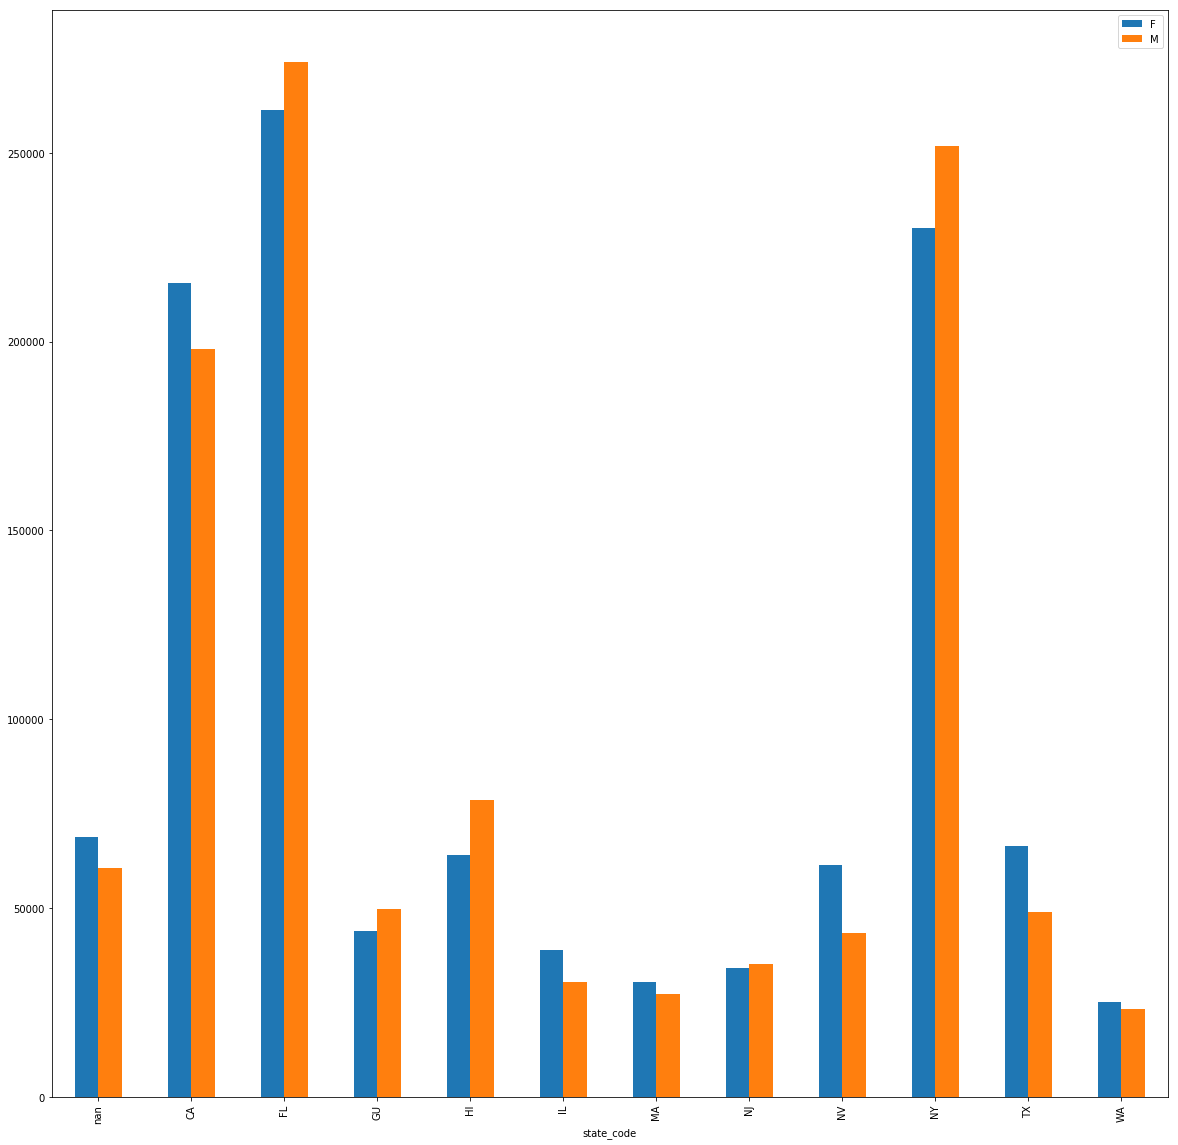

In [65]:
# Remove immigrant states with less than 20,000 immigrants per year
df_state_gender.drop(df_state_gender[df_state_gender['count'] <= 20000].index, inplace=True)
# Create barplot
df = df_state_gender.set_index(['state_code', 'gender']).unstack()[[('count', 'M'),('count', 'F')]]
df.columns=['F', 'M']
df.plot(kind='bar', figsize=(20, 20))

##### Question 2: What does the distribution of Visa Type by Gender look like?

In [66]:
df_visa_gender = spark.sql("SELECT count(cic_id) as count, gender, visa_type FROM immigration_data_view WHERE gender IN ('M', 'F') GROUP BY gender, visa_type" ) 
df_visa_gender = df_visa_gender.toPandas()
df_visa_gender.head()

,count,gender,visa_type
0,10,M,SBP
1,8,M,M2
2,981,F,E1
3,13882,M,E2
4,2761,M,E1


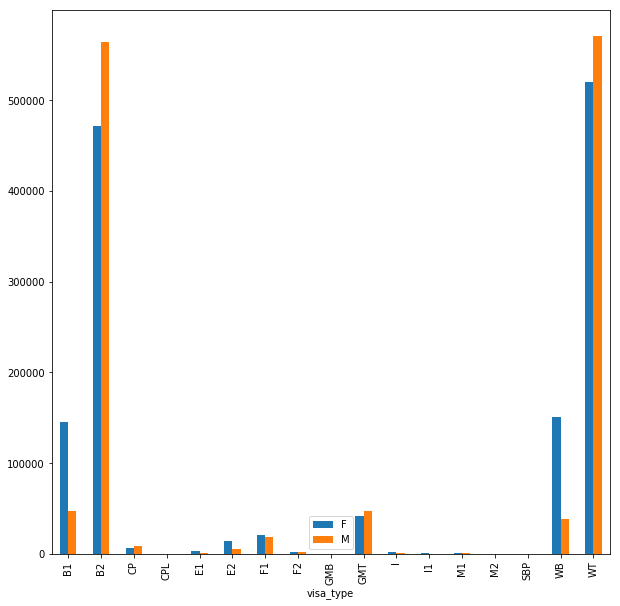

In [67]:
# Create barplot
df = df_visa_gender.set_index(['visa_type', 'gender']).unstack()[[('count', 'M'),('count', 'F')]]
df.columns=['F', 'M']
df.plot(kind='bar', figsize=(10, 10))

#### 5. Project Write Up

##### 5.1 The rationale for the chosen tools and technologies
* [AWS S3](https://aws.amazon.com/s3/) for data storage.
* Apache Spark ([PySpark](https://spark.apache.org/docs/latest/api/python/#:~:text=PySpark%20is%20an%20interface%20for,data%20in%20a%20distributed%20environment.)) processing the data and creating fact and dimension tables.

##### 5.2 Data update frequency
* The immigration fact and immigrant demographics dimension table, and temperature table should be updated on a monthly schedule as the raw data is aggregated on a monthly time period.
* The US city demographics table can be updated depending on the refresh time period of the raw data, which, given how involved it is to update census data, probably annually.

##### 5.3 Future work
5.3.1 The data was increased by 100x
* It seems unlikely that a 100x increase in the data size would be efficiently processes by Apache Spark in standalone server mode and a cloud big data plaform for running large-scale distributed processing jobs such as [Amazon EMR](https://aws.amazon.com/emr/) should be considered to scale.

5.3.2 The data populates a dashboard that must be updated on a daily basis by 7am every day.
* [Apache Airflow](https://airflow.apache.org/) can be used for building out an ETL data pipeline that automates the tasks of processing fresh data and updating the dashboard on a daily basis by 7am.   
 
5.3.3 The database needed to be accessed by 100+ people.
* In this scenario we would move our single-source-of-truth database to a cloud dataware house such as [Amazon Redshift](https://aws.amazon.com/redshift/).